# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

## Keras Update

In [ ]:
!pip install keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00


In [ ]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2024-10-17 05:28:00--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  19.5MB/s    in 7.5s    

2024-10-17 05:28:08 (14.9 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import io

## Data Loading

In [ ]:
data = io.loadmat('notMNIST_small.mat')

In [ ]:
x = data['images']
y = data['labels']

In [ ]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [ ]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [ ]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

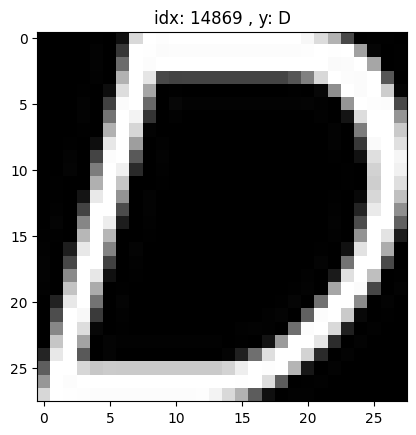

In [ ]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='gray' )
plt.show()

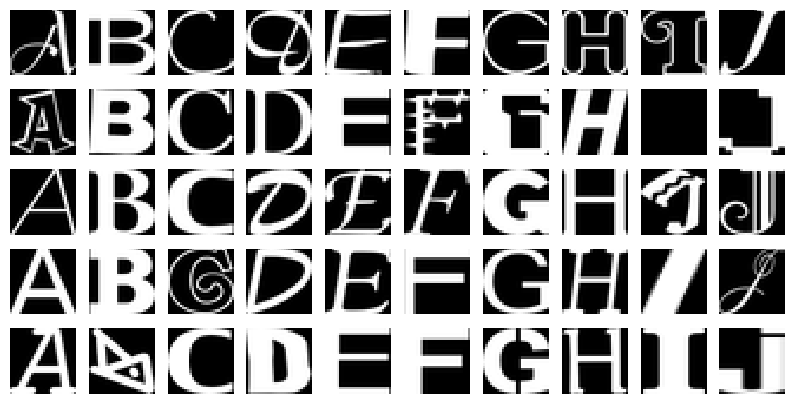

In [ ]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='gray', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split
    - training set : test set = 8 : 2
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2024)

In [ ]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((11983, 28, 28, 1),
 (11983,),
 (2996, 28, 28, 1),
 (2996,),
 (3745, 28, 28, 1),
 (3745,))

* Scaling

    - min-max scaling

In [ ]:
max_n, min_n = train_x.max(), train_x.min()

In [ ]:
train_x = (train_x - min_n) / (max_n - min_n)
val_x = (val_x - min_n) / (max_n - min_n)
test_x = (test_x - min_n) / (max_n - min_n)

In [ ]:
train_x.max(), train_x.min()

(1.0, 0.0)

* One-hot encoding

In [ ]:
from keras.utils import to_categorical

In [ ]:
train_y = to_categorical(train_y, classes)
val_y = to_categorical(val_y, classes)
test_y = to_categorical(test_y, classes)

* Data shape 재확인

In [ ]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((11983, 28, 28, 1),
 (11983, 10),
 (2996, 28, 28, 1),
 (2996, 10),
 (3745, 28, 28, 1),
 (3745, 10))

## **Image Precessing&Augmentation Layers**

In [ ]:
import keras

In [ ]:
aug_layers = [keras.layers.RandomRotation(factor=(-0.3,0.3)),
              keras.layers.RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3)),
              keras.layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
              keras.layers.RandomFlip(mode='horizontal_and_vertical')
              ]

In [ ]:
def image_augmentation(images):
    for layer in aug_layers:
        images = layer(images)
    return images

In [ ]:
aug_imgs = image_augmentation(train_x[0])

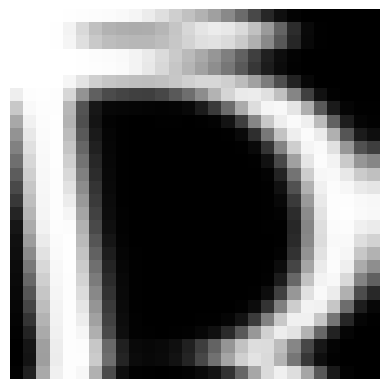

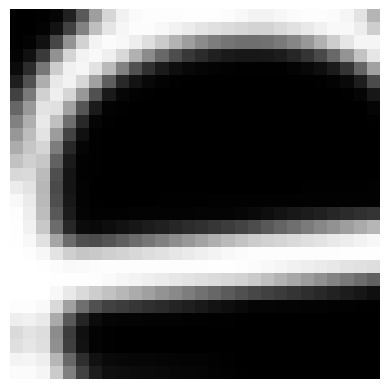

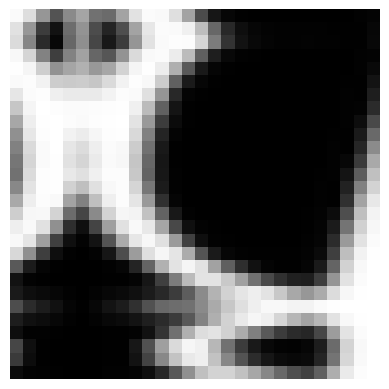

In [ ]:
rand_n = np.random.randint(0, 11982)

for i in range(3) :
    aug_imgs = image_augmentation(train_x[rand_n])

    plt.imshow( np.array(aug_imgs), cmap='gray' )
    plt.axis('off')
    plt.show()

## Modeling : CNN + **Image Precessing&Augmentation**

- 조건
    1. Sequential API, Functional API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

In [ ]:
## Sequential API
keras.utils.clear_session()

model1 = keras.models.Sequential()

model1.add( keras.layers.Input(shape=(28,28,1)) )

for layer in aug_layers :
    model1.add( layer )

model1.add( keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model1.add( keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model1.add( keras.layers.MaxPool2D((2,2)) )
model1.add( keras.layers.BatchNormalization() )
model1.add( keras.layers.Dropout(0.4) )

model1.add( keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model1.add( keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model1.add( keras.layers.MaxPool2D((2,2)) )
model1.add( keras.layers.BatchNormalization() )
model1.add( keras.layers.Dropout(0.4) )

model1.add( keras.layers.Flatten() )
model1.add( keras.layers.Dense(10, activation='softmax') )

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,746 (377.91 KB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy']
               )

In [ ]:
## Functional API
keras.utils.clear_session()

il = keras.layers.Input(shape=(28,28,1))

for idx, aug_l in enumerate(aug_layers) :
    if idx==0 :
        al = aug_l(il)
    else :
        al = aug_l(al)

hl = keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu')(al)
hl = keras.layers.Conv2D(32, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.MaxPool2D((2,2))(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.4)(hl)

hl = keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.Conv2D(64, (3,3), (1,1), 'same', activation='relu')(hl)
hl = keras.layers.MaxPool2D((2,2))(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.4)(hl)

hl = keras.layers.Flatten()(hl)
ol = keras.layers.Dense(10, activation='softmax')(hl)

model2 = keras.models.Model(il, ol)
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          31,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,746 (377.91 KB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()]
               )

* Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
es = EarlyStopping('val_loss', 0, 5, 1,
                   restore_best_weights=True
                   )

* .fit( )

In [ ]:
model2.fit(train_x, train_y, validation_data=(val_x, val_y),
           epochs=2, verbose=1,
           callbacks=[es]
           )

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.1885 - loss: 2.8272 - val_categorical_accuracy: 0.1565 - val_loss: 3.1006
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - categorical_accuracy: 0.2647 - loss: 2.2415 - val_categorical_accuracy: 0.2704 - val_loss: 2.3103
Restoring model weights from the end of the best epoch: 1.


* .evaluate( )

In [ ]:
model2.evaluate(test_x, test_y)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.1546 - loss: 3.0750


[3.05293345451355, 0.15887850522994995]

* .predict( )

In [ ]:
y_pred = model2.predict(test_x)
y_pred[0]

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([4.0488616e-02, 5.3866178e-01, 1.7705921e-02, 3.6323957e-02,
       1.6008261e-01, 2.1703383e-02, 1.4645435e-01, 3.7174724e-02,
       1.1624895e-03, 2.4219594e-04], dtype=float32)

In [ ]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y, axis=1)

* 평가 지표

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
accuracy_score(test_y_arg, y_pred_arg)

0.1588785046728972

In [ ]:
print( classification_report(test_y_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       360
           1       0.19      0.81      0.30       382
           2       0.00      0.00      0.00       385
           3       0.33      0.00      0.01       373
           4       0.06      0.06      0.06       364
           5       0.00      0.00      0.00       392
           6       0.15      0.66      0.25       390
           7       0.00      0.00      0.00       364
           8       1.00      0.00      0.01       360
           9       0.00      0.00      0.00       375

    accuracy                           0.16      3745
   macro avg       0.17      0.15      0.06      3745
weighted avg       0.17      0.16      0.06      3745



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualization

* 실제 데이터 확인

idx = 2392
해당 인덱스의 이미지는 E
모델의 예측 : G
모델의 클래스별 확률 : 
-------------------
A 0.0
B 26.0
C 1.0
D 10.0
E 17.0
F 1.0
G 38.0
H 4.0
I 0.0
J 0.0
땡


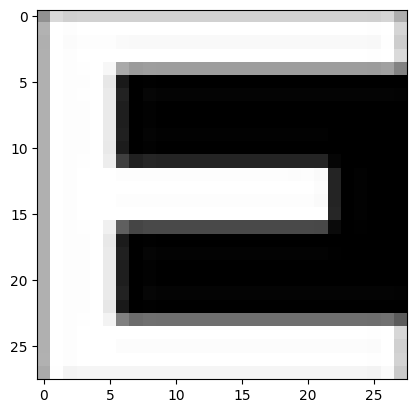

In [ ]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()

* 틀린 이미지만 확인해보기

In [ ]:
len(test_y)

3745

In [ ]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

3150

idx = 1230
해당 인덱스의 이미지는 E
모델의 예측 : G
모델의 클래스별 확률 : 
-------------------
A 0.0
B 9.0
C 2.0
D 5.0
E 8.0
F 0.0
G 66.0
H 5.0
I 0.0
J 0.0
땡


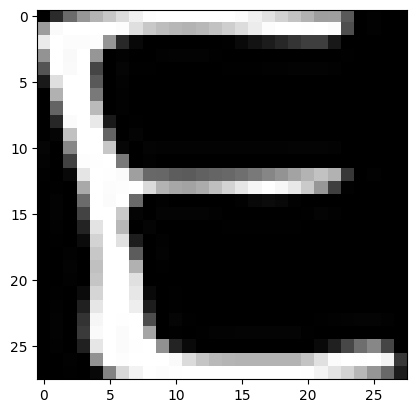

In [ ]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()